<a href="https://colab.research.google.com/github/seven320/air_pollutants/blob/main/FP025_022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Env

In [1]:
!nvidia-smi

Mon May  9 03:36:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os, sys
COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
if COLAB:
    !pip install transformers > /dev/null
    !pip install einops > /dev/null
    !pip install optuna > /dev/null
    !pip install pyephem > /dev/null
    # !pip install timm > /dev/null
    # !pip install kaggle > /dev/null
    # !pip install kaggle_datasets > /dev/null
    # !pip install git+https://github.com/albumentations-team/albumentations
    # !pip install tensorflow-determinism
    !pip install -q iterative-stratification
    !pip install python-Levenshtein > /dev/null
    !pip install geopy > /dev/null

    # for gpu
    !git clone --recursive https://github.com/Microsoft/LightGBM
    %cd /content/LightGBM/
    !mkdir build
    !cmake -DUSE_GPU=1 
    !make -j$(nproc)
    !sudo apt-get -y install python-pip

    !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
    #pandasのエラーが出る場合は上記のコードからpandasを削除

    !sudo -H pip install setuptools numpy scipy scikit-learn -U
    %cd /content/LightGBM/python-package
    !sudo python setup.py install --precompile

    output.clear()

In [4]:
import gc
import json
import math
import os
import random
import re
import time
import copy
import warnings
from requests import get
from contextlib import contextmanager
from typing import List, Optional, TypeVar, Type, Dict
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, train_test_split, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
# from einops.layers.torch import Rearrange, Reduce
# import timm
import Levenshtein
import ephem
from geopy.distance import geodesic

from tqdm.notebook import tqdm
from transformers import AdamW, get_cosine_schedule_with_warmup
from typing import Optional, Tuple
from xgboost import XGBRegressor
import lightgbm as lgb
import optuna

In [5]:
warnings.simplefilter('ignore')

In [6]:
if COLAB:    
    NOTEBOOK_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    print(NOTEBOOK_NAME)

FP025-022


In [7]:
COMPE_NAME = "air_pollutants"
BASE_DIR = f"/content/drive/MyDrive/signate/{COMPE_NAME}"

# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

In [8]:
if COLAB:
    INPUT_DIR = Path(os.path.join(BASE_DIR ,f"input"))
    INPUT_DIR.mkdir(exist_ok=True, parents=True)

    SAVE_DIR = Path(os.path.join(BASE_DIR ,f"models/{NOTEBOOK_NAME}"))
    SAVE_DIR.mkdir(exist_ok=True, parents=True)

    OOF_DIR = Path(os.path.join(BASE_DIR, f"oof/{NOTEBOOK_NAME}"))
    OOF_DIR.mkdir(exist_ok=True, parents = True)

    SUB_DIR = Path(os.path.join(BASE_DIR, f"submission/{NOTEBOOK_NAME}"))
    SUB_DIR.mkdir(exist_ok=True, parents = True)

In [9]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sample_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "predict"])

print(train_df.shape, test_df.shape, sample_df.shape)

(195941, 54) (53509, 53) (53509, 2)


## add city population

In [10]:
population_df = pd.read_csv(os.path.join(INPUT_DIR, "city_population.csv"))
population_df["City"] = population_df["Name"]

In [11]:
# 同じ都市名かつ国名のものを削除する
population_df["CC"] = population_df["Country"] + population_df["City"]
population_df["CC"].value_counts()
for k, v in population_df["CC"].value_counts().items():
    # print(k, v)
    if v > 1:
        print(f"{k} の行を削除")
        population_df = population_df[population_df["CC"] != k]

ChinaSuzhou の行を削除


In [12]:
def df_to_country_dict(df: pd.DataFrame) -> Dict:
    country_city = {}

    for t_c in set(df["Country"].tolist()):
        country_city[t_c] = []

    for country, city in zip(df["Country"], df["City"]):
        country_city[country].append(city)

    for k, v in country_city.items():
        country_city[k] = set(v)

    return country_city
    

In [13]:
train_country_city = df_to_country_dict(pd.concat([train_df, test_df]))

p_country_city = df_to_country_dict(population_df)

In [14]:
def cal_leven(str1: str, str2: str) -> float:
    # レーベンシュタイン距離の取得
    lev_dist = Levenshtein.distance(str1, str2)
    # 標準化(長い方の文字列の長さで割る)
    divider = len(str1) if len(str1) > len(str2) else len(str2)
    lev_dist = lev_dist / divider
    # 指標を合わせる(0:完全不一致 → 1:完全一致)
    return 1 - lev_dist

In [15]:
city_pairs = {}

for t_k, t_values in train_country_city.items():
    for p_k, p_values in p_country_city.items():
        # countryが一致
        if t_k != p_k:
            continue
        for t_v in t_values:
            max_score = -1
            for p_v in p_values:
                score = cal_leven(t_v, p_v)
                if max_score < score:
                    pairs = [t_v, p_v]
                    max_score = score

            if max_score > 0.8:
                city_pairs[pairs[1]] = pairs[0]
print(f"pair cities:{len(city_pairs)}")

pair cities:177


In [16]:
a = population_df["City"]
for key, value in city_pairs.items():
    # print(key, value)
    a = copy.deepcopy(a.replace(key, value))

population_df["City"] = a

In [17]:
if not "Prev" in train_df.columns:
    train_df = train_df.merge(population_df[["rank", "City", "Country", "Population", "Prev", "Growth"]], on = ["City", "Country"], how="left")
    test_df = test_df.merge(population_df[["rank", "City", "Country",  "Population", "Prev", "Growth"]], on = ["City", "Country"], how="left")

assert len(test_df) == len(sample_df)

## add target encode

In [18]:
if not "target_count" in train_df.columns:
    target_df = train_df[["Country", "pm25_mid"]].groupby("Country", as_index = 1).describe()

    target_df = target_df.rename(columns = {
        "count": "target_count",
        "mean": "target_mean",
        "std": "target_std",
        "25%": "target_25%",
        "50%": "target_50%",
        "75%": "target_75%",
        "max": "target_max"
    }).reset_index()
    train_df = train_df.merge(pd.concat([target_df["Country"], target_df["pm25_mid"]], axis = 1), on = "Country", how = "left")
    test_df = test_df.merge(pd.concat([target_df["Country"], target_df["pm25_mid"]], axis = 1), on = "Country", how = "left")

### add days

## 都市を近い順に入力(上位15)

In [19]:
use_city = 3

In [20]:
# 全ての都市を抽出
all_df = pd.concat([train_df, test_df])
lat_lons = all_df[["City", "lat", "lon"]].drop_duplicates()

In [21]:
 # 各都市ごとの距離を格納
 #
#  nearest_cities = {
#       City1 = {
            # City2: 500km
            # City3: 1000km
# }
# } 

nearest_cities = {}
for i in tqdm(range(len(lat_lons))):
    City1, lat1, lon1 = lat_lons.iloc[i]
    pos1 = np.array([lat1, lon1])
    
    nearest_city = {}
    for j in range(len(lat_lons)):
        if i == j:
            continue
        
        City2, lat2, lon2 = lat_lons.iloc[j]
        pos2 = np.array([lat2, lon2])
        
        dis = geodesic(pos1, pos2)
        
        nearest_city[City2] = dis

    nearest_cities[City1] = nearest_city

  0%|          | 0/302 [00:00<?, ?it/s]

In [22]:
target_en_bycities = all_df[["City", "pm25_mid"]].groupby(["City"], as_index = 0).agg("mean").reset_index(drop=True)

In [23]:
nearest_sort_cities = []

for city1 in nearest_cities.keys():
    nearest_sort_city = dict(sorted(nearest_cities[city1].items(), key = lambda item: item[1])).keys()
    nearest_sort_cities.append([city1] + list(nearest_sort_city)[:use_city])

In [24]:
# # validationの数値がある中で最も近い都市のtargetを引っ張ってくる
# if not "near_city" in train_df.columns:
#     train_df = train_df.merge(nearest_city_df, on = "City", how="left")
#     test_df = test_df.merge(nearest_city_df, on = "City", how="left")

# assert len(test_df) == len(sample_df)

# Fold

In [25]:
# Config
NUM_FOLDS = 5

In [26]:
#############
## Utility ##
#############
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    print(f"[{name}] done - elapsed {time.time() - t0:.2f}s")

In [27]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [28]:
train_df.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,Prev,Growth,target_count,target_mean,target_std,min,target_25%,target_50%,target_75%,target_max
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,2439467.0,0.0134,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,NaN,NaN,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,5061439.0,0.0176,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,NaN,NaN,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,2067333.0,0.0122,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517


In [29]:
train_city = train_df["City"].unique().tolist()
test_city = test_df["City"].unique().tolist()

train_city_cnt = len(train_city)
test_city_cnt = len(test_city)

print(f"train city count: {train_city_cnt}")
print(f"test city count: {test_city_cnt}")

print(f"{len(set(train_city) & set(test_city))}")

train city count: 239
test city count: 63
0


In [30]:
kf = GroupKFold(n_splits = NUM_FOLDS)

if not "kfold" in train_df.columns:
    folds = copy.deepcopy(train_df[["id"]])
    folds["kfold"] = -1

    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df, train_df["pm25_mid"], train_df["City"])):
        print(f"train_idx: {len(train_idx)}, valid_idx: {len(valid_idx)}")
        folds.loc[valid_idx, "kfold"] = fold

    train_df = train_df.merge(folds[["id", "kfold"]], on="id", how="left")

train_idx: 156755, valid_idx: 39186
train_idx: 156758, valid_idx: 39183
train_idx: 156760, valid_idx: 39181
train_idx: 156730, valid_idx: 39211
train_idx: 156761, valid_idx: 39180


# Train

In [31]:
import logging
from typing import List, Optional, TypeVar

import pandas as pd

class AbstractFeatureTransformer:
    def __init__(self):
        self.name = self.__class__.__name__

    def fit_transform(self, input_df: pd.DataFrame, y=None):
        self.fit(input_df, y)
        return self.transform(input_df)

    def fit(self, input_df: pd.DataFrame, y=None):
        pass

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError

Transformer = TypeVar("Transformer", bound=AbstractFeatureTransformer)

def extract_features(input_df: pd.DataFrame,
                     transformers: List[Transformer],
                     fit: bool = True,
                     logger: Optional[logging.Logger] = None):
    feature_dfs = []
    for transformer in transformers:
        # timerはブロックの実行時間を計測するユーティリティ
        with timer(f"Extract features with {transformer.name}", logger):
            if fit:
                feature_dfs.append(transformer.fit_transform(input_df))
            else:
                feature_dfs.append(transformer.transform(input_df))
    all_features = pd.concat(feature_dfs, axis=1)
    return all_features

In [32]:
class Numericals(AbstractFeatureTransformer):
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        cols = [pd.api.types.is_numeric_dtype(dtype) for dtype in input_df.dtypes]
        return input_df.loc[:, cols]

class LabelEncoding(AbstractFeatureTransformer):
    def __init__(self, columns: List[str]):
        super().__init__()
        self.le_columns = columns
        self.encoders = {
            column: LabelEncoder()
            for column in self.le_columns
        }
        self.__is_fitted = False

    def fit(self, input_df: pd.DataFrame, y: Optional[np.ndarray] = None):
        """
        ラベルに変換する前に欠損値を埋める
        """
        for column in self.le_columns:
            self.encoders[column].fit(input_df[column].fillna(""))
        self.__is_fitted = True

    def transform(
        self, 
        input_df: pd.DataFrame, 
        y: Optional[np.ndarray] = None
    ) -> pd.DataFrame:
        assert self.__is_fitted, "You need to call `fit` first."
        encoded = {}
        for column in self.le_columns:
            encoded[column] = self.encoders[column].transform(
                input_df[column].fillna(""))
        return pd.DataFrame(encoded)

In [33]:
def preprocess(df:pd.DataFrame)->pd.DataFrame:
    df_ = copy.deepcopy(df)
    # 年月/年月日を追加

    df_["year_month"] = df_["year"].astype("str") + df_["month"].astype("str")
    df_["year_month_day"] = df_["year"].astype("str") + df_["month"].astype("str") + df_["day"].astype("str")
    df_["month_day"] = df_["month"].astype("str") + df_["day"].astype("str")




    
    # 月日国/月日都市を追加
    df_["month_day_country"] = df_["month"].astype("str") + df_["day"].astype("str") + df_["Country"].astype("str") 
    df_["month_day_city"] =  df_["month"].astype("str") + df_["day"].astype("str") + df_["City"].astype("str") 

    # 経度をcosに変換
    cnt = 0

    if not "lon_cos" in df_.columns:
        df_["lon_cos"] = np.cos(np.radians((df_["lon"] + 180)))
        df_["lon_sin"] = np.sin(np.radians((df_["lon"] + 180)))
        df_["month_cos"] = np.cos(np.radians(df_["month"] / 12 * 360))
        df_["month_sin"] = np.sin(np.radians(df_["month"] / 12 * 360))
        print("add lon_cos, lon_sin, month_cos, month_sin")
        cnt += 4

    # 四則演算

    # 南半球を北半球のmonthに変更
    if not "month_world" in df_.columns:
        df_["month_world"] = df_["month"]
        df_.loc[df_["lat"] < 0, "month_world"] = df_["month"] + 6
        df_.loc[df_["month_world"] > 12, "month_world"] = df_["month"] - 6
        print("add month_world")
        cnt += 1
    # mid同士を4則
    columns = df_.columns
    mids = []
    for c in columns:
        if "_mid" in c and c != "pm25_mid":
            mids.append(c)
    scaler = MinMaxScaler()

    # 曜日を追加
    def _cal_sun_time(lat:float, lon:float, year:float, month:float, day: float)->float:
        location = ephem.Observer()
        location.lat = str(lat)
        location.lon = str(lon)
        sun = ephem.Sun()

        location.date = datetime.date(year = int(year), month = int(month), day = int(day))
        sun_time_tmp1 = ephem.localtime(location.next_rising(sun)) - ephem.localtime(location.next_setting(sun))
        sun_time_tmp2 = ephem.localtime(location.next_setting(sun)) - ephem.localtime(location.next_rising(sun))

        sun_time = max(sun_time_tmp1.seconds, sun_time_tmp2.seconds)

        return sun_time
    if not "sun_time" in df_.columns:
        u_cols = ["lat", "lon", "year", "month", "day"]

        df_["sun_time"] = -1
        df_["week"] = -1

        mini_df = df_[u_cols]

        sun_time = np.zeros(len(df_))
        weeks = np.zeros(len(df_))
        for i in tqdm(range(len(mini_df))):
            lat, lon, year, month, day = mini_df.iloc[i]
            sun_time[i] = _cal_sun_time(lat, lon, year, month, day)

            # 曜日
            date = datetime.date(int(year), int(month), int(day))
            weeks[i] = date.weekday()

        df_["sun_time"] = sun_time
        df_["week"] = weeks

        print("add sun_time, weeks")
    cnt += 2
    mids = ["co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid"]
    for i in range(len(mids)):
        for j in range(i):
            mid0, mid1 = mids[i], mids[j]
            df_[f"{mid0}+{mid1}"] = df_[mid0] + df_[mid1]

            cnt += 1
    print("add mids + cal")
    print(f"add {cnt} columns")

    return df_

In [34]:
# numericals = Numericals()
# 数字に関する変換
# train_df_num = numericals.transform(train_df)

# ラベルに関する変換
# labelencoding = LabelEncoding(columns = [])

# labelencoding.fit(train_df_num)
# train_df_labeled = labelencoding.transform(train_df_num)

In [35]:
class AbstractTreeModel:
    def __init__(self, prediction_type="regression"):
        self.model = None
        self.prediction_type = prediction_type

    def train(self,
              params: dict,
              X_train: pd.DataFrame,
              y_train: np.ndarray,
              X_val: pd.DataFrame,
              y_val: np.ndarray,
              train_weights: Optional[np.ndarray] = None,
              val_weights: Optional[np.ndarray] = None,
              train_params: Optional[dict] = None):
        if train_params is None:
            train_params = {}

        model = self._train(
            params,
            X_train, y_train,
            X_val, y_val,
            train_weights, val_weights,
            train_params)
        self.model = model
        return self

    def _train(self,
               params,
               X_train,
               y_train,
               X_val,
               y_val,
               train_weights,
               val_weights,
               train_params):
        raise NotImplementedError

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        raise NotImplementedError

    @property
    def feature_names_(self):
        raise NotImplementedError

    @property
    def feature_importances_(self):
        raise NotImplementedError

    def _check_if_trained(self):
        assert self.model is not None, "You need to train the model first"

class LGBModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        trn_data = lgb.Dataset(X_train, y_train, weight=train_weights)
        val_data = lgb.Dataset(X_val, y_val, weight=val_weights)
        model = lgb.train(params=params,
                          train_set=trn_data,
                          valid_sets=[trn_data, val_data],
                          **train_params,)
                        #   verbose_eval=False)
        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X, num_iteration=self.model.best_iteration)

    @property
    def feature_names_(self):
        self._check_if_trained()
        return self.model.feature_name()

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importance(importance_type="gain")

def get_tree_model(name: str) -> Type[AbstractTreeModel]:
    DEFINED_MODELS = {
        "lgb": LGBModel,
        # 実装していない
        # "xgb": XGBModel,
        # "cat": CatBoostModel
    }
    model = DEFINED_MODELS.get(name)
    if model is None:
        raise ValueError(
            """Invalid model name: {}.
            Pre-defined model names are as follows: {}""".format(
                name,
                ",".join(DEFINED_MODELS.keys())
            ))
    return model

In [36]:
def viz_feature_importances(feature_importances: pd.DataFrame)-> None:
    fi_gby = feature_importances.groupby("feature").agg({
        "importance": ["mean", "std"]
    }).sort_values(("importance", "mean"), ascending=0).index
    plt.figure(figsize=(30, 20))

    sns.barplot(x="importance", y="feature", data=feature_importances, order=fi_gby)

    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    # plt.savefig('lgbm_importances-01.png')

In [37]:
train_params = {
    "num_boost_round": 10000,
    "callbacks": [
                  lgb.early_stopping(stopping_rounds= 200, verbose=True),
                  lgb.log_evaluation(period = 500)
    ]
}

In [38]:
num_cols = [c for c in train_df.columns if train_df[c].dtype != np.object]
if "id" in num_cols:
    num_cols.remove("id")
if "kfold" in num_cols:
    num_cols.remove("kfold")
num_cols.remove("pm25_mid")

target_cols = "pm25_mid"

In [39]:
train_df_ = preprocess(train_df)
test_df_ = preprocess(test_df)

add lon_cos, lon_sin, month_cos, month_sin
add month_world


  0%|          | 0/195941 [00:00<?, ?it/s]

add sun_time, weeks
add mids + cal
add 43 columns
add lon_cos, lon_sin, month_cos, month_sin
add month_world


  0%|          | 0/53509 [00:00<?, ?it/s]

add sun_time, weeks
add mids + cal
add 43 columns


In [40]:
cat_cols = ["Country", "City", "year_month", "year_month_day", "month_day", "month_day_city", "month_day_country"] 

num_cols = list(set(train_df_.columns) - set(cat_cols + ["pm25_mid", "kfold", "id"]))
use_cols = num_cols + cat_cols

In [41]:
# num_cols

In [42]:
params= {
        'boosting': 'gbdt',
        'objective': 'rmse',
        'metric': 'rmse',
        'learning_rate': 0.01,
        "max_depth": 16,
        "num_leaves": 64,
        'subsample': 0.7,
        'subsample_freq': 1,
        "min_data_in_leaf":30, 
        "device": "gpu",  
        "seed":2022,
}

seeds = 5

In [43]:
models = []

oof_df = train_df_[["id"]]
oof_df["oof"] = -1

from lightgbm import early_stopping
from lightgbm import log_evaluation

test_df__ = copy.deepcopy(test_df_)

for i in range(NUM_FOLDS):
    oofs = []
    for seed in range(seeds):
        model = get_tree_model("lgb")()
        train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
        valid_data = train_df_[train_df_["kfold"] == i].reset_index(drop = True)
        print("-" * 5 + f"FOLD {i + 1}/{NUM_FOLDS}" + "-"*5)
        print(f"train_data nums: {len(train_data)}, valid_data nums: {len(valid_data)}")

        # fold内での最近傍を探す
        train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
        print(len(train_data["City"].unique()))

        for c in cat_cols:
            le = LabelEncoder()
            le.fit(pd.concat([train_df_, test_df_])[c])
            train_data[c] = le.transform(train_data[c])
            valid_data[c] = le.transform(valid_data[c])
            if i == 0:
                test_df__[c] = le.transform(test_df_[c])

        model.train(
            params,
            train_params = train_params,
            X_train = train_data[use_cols],
            y_train = train_data[target_cols],
            X_val = valid_data[use_cols],
            y_val = valid_data[target_cols],
        )
        models.append(model)

        feature_importance = pd.DataFrame()
        feature_importance["feature"] = model.feature_names_
        feature_importance["importance"] = model.feature_importances_
        feature_importance["fold"] = i

        oof = model.predict(
            valid_data[use_cols]
        )
        oofs.append(oof)
    
    oof_df.loc[train_df["kfold"] == i, "oof"] = sum(oofs) / seeds

train_oof = train_df.merge(oof_df[["id", "oof"]], on = "id", how = "left")

-----FOLD 1/5-----
train_data nums: 156755, valid_data nums: 39186
192
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 23687
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 112
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 112 dense feature groups (16.74 MB) transferred to GPU in 0.023900 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 19.5903	valid_1's rmse: 24.8536
[1000]	training's rmse: 18.316	valid_1's rmse: 24.3885
[1500]	training's rmse: 17.5097	valid_1's rmse: 24.2711
Early stopping, best iteration is:
[1766]	training's rmse: 17.1564	valid_1's rmse: 24.2317
-----FOLD 1/5-----
train_da

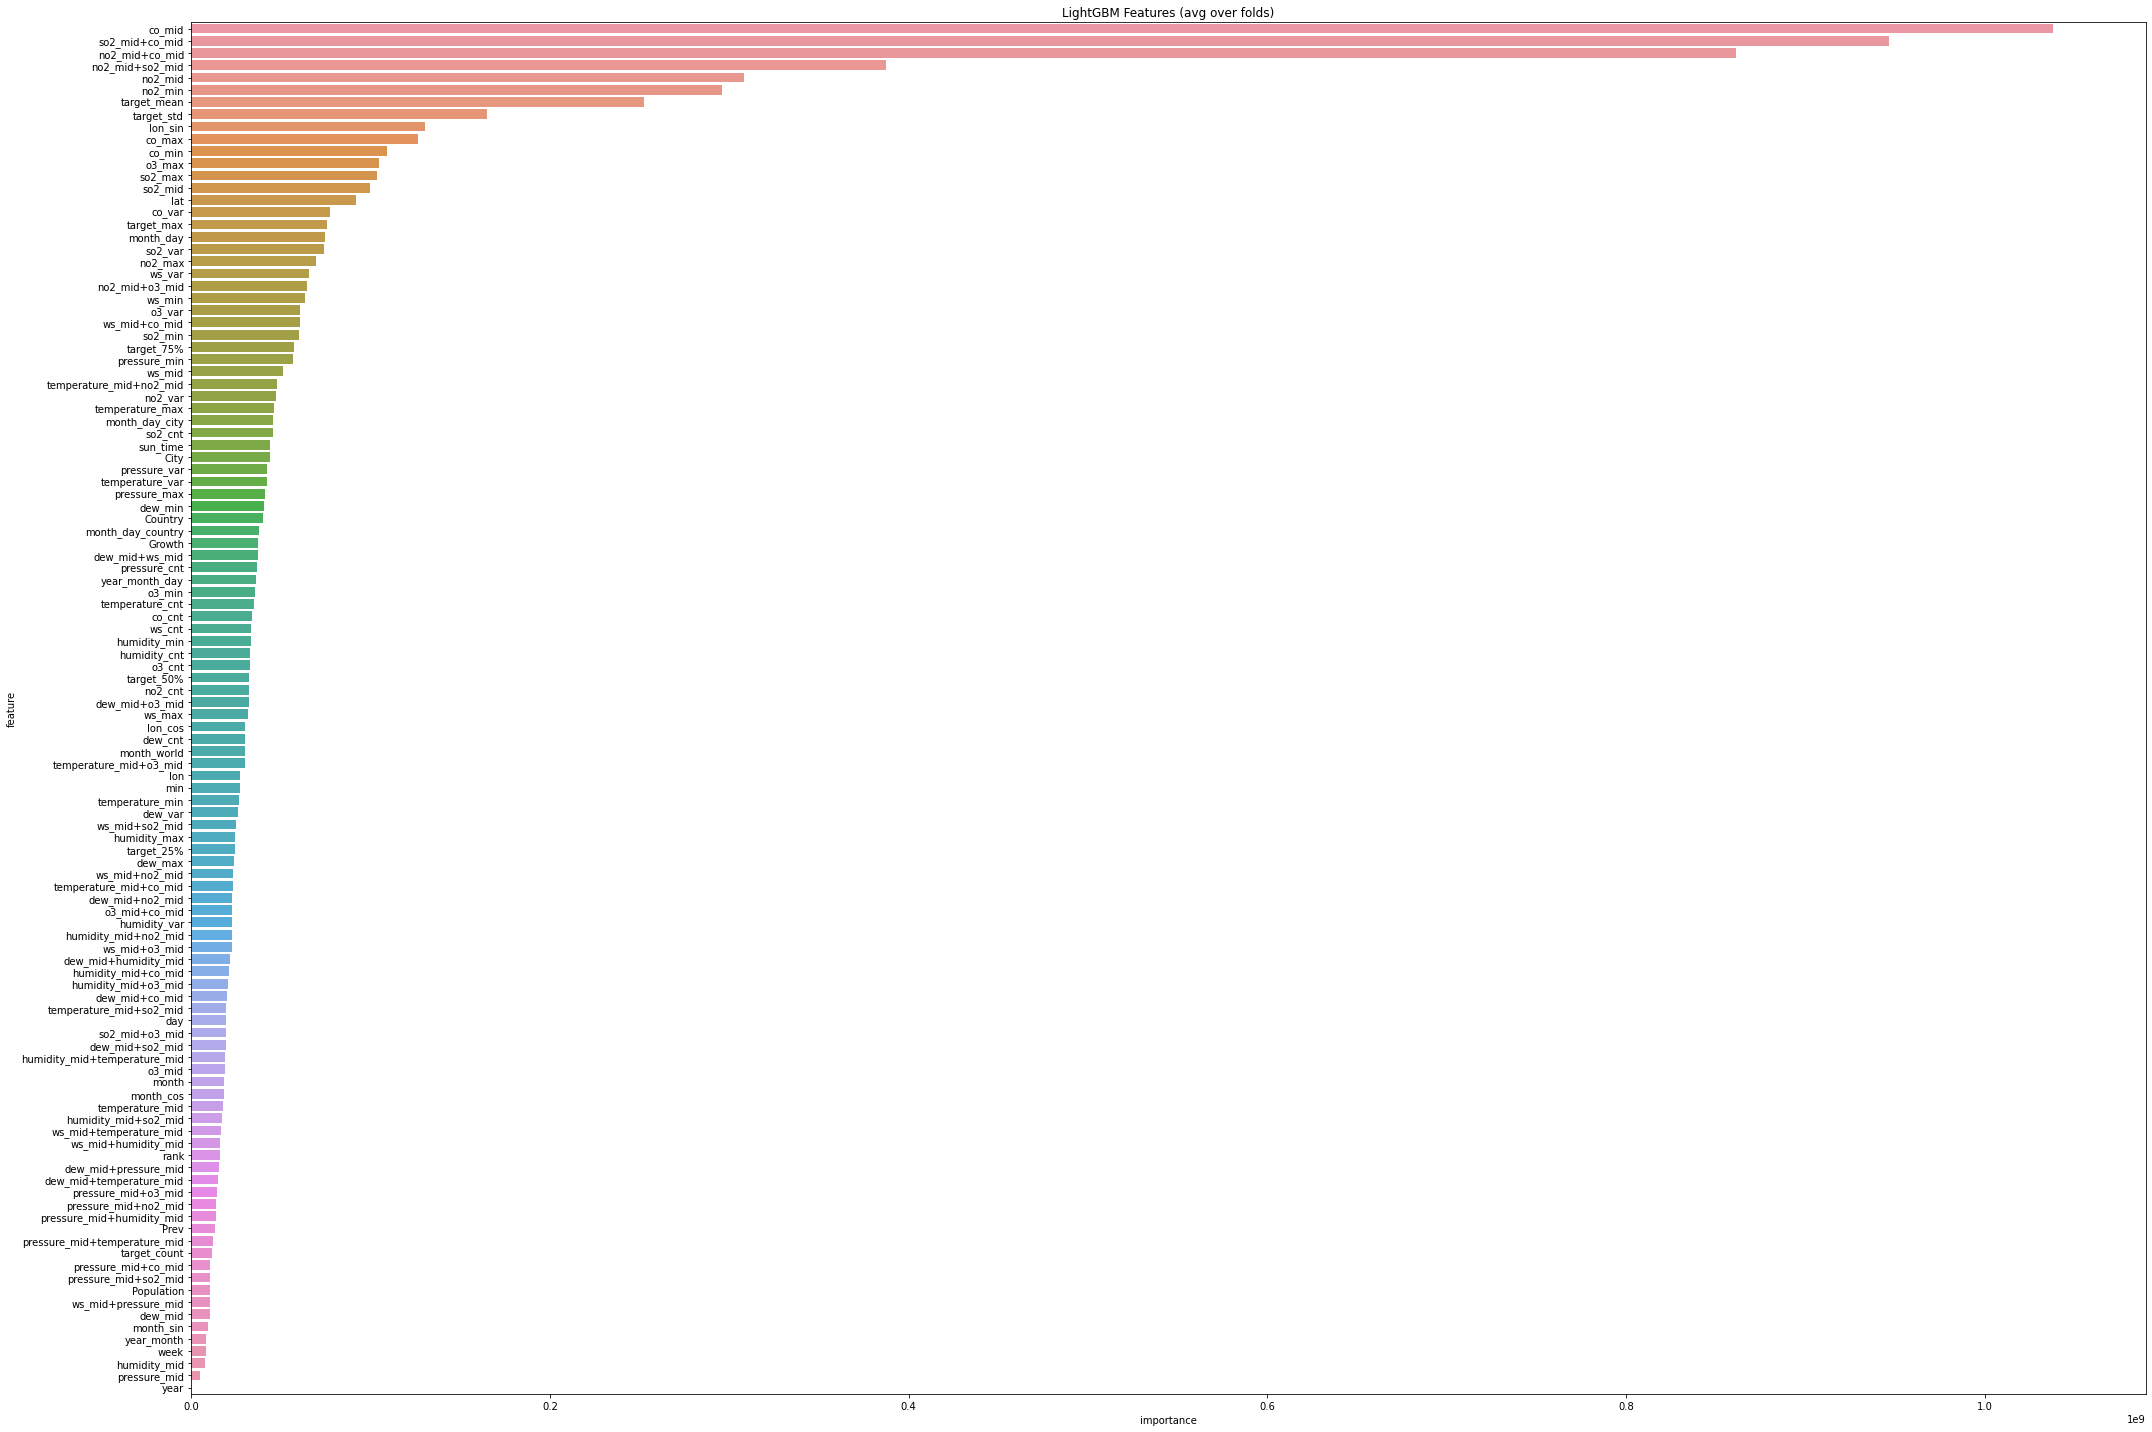

In [44]:
viz_feature_importances(feature_importance)

In [45]:
a = np.clip(train_oof["oof"], 0, 450)

In [46]:
oof_score = np.sqrt(mean_squared_error(train_oof["pm25_mid"], a))
oof_score = format(oof_score, ".4f")
print(f"oof score: {oof_score}")

### d_cs_flg 21.89 ###

# 24.11
# 20.85

oof score: 21.8848


In [47]:
train_oof[["id","pm25_mid", "kfold", "oof"]].to_csv(os.path.join(OOF_DIR, "oof.csv"), index= False)

# predict

In [48]:
sum_predict = None
for model in models:
    predict = model.predict(
        test_df__[use_cols],
    )
    if sum_predict is None:
        sum_predict = predict
    else:
        sum_predict += predict

mean_predict = sum_predict / len(models)

In [49]:
print(len(mean_predict))
print(sample_df.shape)
print(test_df.shape)

53509
(53509, 2)
(53509, 65)


In [50]:
sample_df.loc[:,"predict"] = np.clip(mean_predict, 0, 450)

In [51]:
sample_df.head()

,id,predict
0,195942,26.382237
1,195943,38.027167
2,195944,24.377642
3,195945,58.302225
4,195946,133.464125


In [52]:
sample_df.to_csv(os.path.join(SUB_DIR, "submission.csv"), index= False, header = False)

# submit

In [53]:
!pip install signate > /dev/null
!mkdir /root/.signate
!cp /content/drive/MyDrive/signate/signate.json /root/.signate/signate.json

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [54]:
submission_file = os.path.join(SUB_DIR, "submission.csv")

In [55]:
comment = f"cv:{oof_score}_" + NOTEBOOK_NAME
comment

'cv:21.8848_FP025-022'

# Submit

In [62]:
!signate submit --competition-id=624 {submission_file} --note {comment}

You have successfully submitted your predictions.We will send you the submission result to your email address.


https://signate.jp/competitions/624/submissions

In [57]:
train_df[["City", "month", "pm25_mid"]].groupby(["City"]).describe()

month                                                pm25_mid  \
              count      mean       std  min  25%  50%   75%   max    count   
City                                                                          
Adapazarı     962.0  6.536383  3.356269  1.0  4.0  6.0   9.0  12.0    962.0   
Akita         978.0  6.527607  3.436774  1.0  4.0  6.0  10.0  12.0    978.0   
Albuquerque   917.0  6.679389  3.347707  1.0  4.0  7.0  10.0  12.0    917.0   
Andong       1011.0  6.608309  3.431492  1.0  4.0  7.0  10.0  12.0   1011.0   
Antakya       734.0  6.779292  3.200069  1.0  4.0  7.0  10.0  12.0    734.0   
...             ...       ...       ...  ...  ...  ...   ...   ...      ...   
Zhuzhou      1059.0  6.610954  3.425374  1.0  4.0  7.0  10.0  12.0   1059.0   
Ürümqi       1033.0  6.642788  3.399611  1.0  4.0  7.0  10.0  12.0   1033.0   
İzmit        1013.0  6.553801  3.346923  1.0  4.0  7.0   9.0  12.0   1013.0   
Łódź          753.0  6.701195  3.238681  1.0  4.0  7.0   9.0  12.0    753.0   
Ōita         1057.0  6.621570  3.406298  1.0  4.0  7.0  10.0  12.0   1057.0   

                                                                         \
                  mean        std     min       25%      50%        75%   
City                                                                      
Adapazarı    63.232831  35.395245   6.460  39.56125  55.6930   73.47475   
Akita        45.871133  25.458542   6.364  28.59525  40.5160   57.69725   
Albuquerque  42.865439  28.188976   7.736  22.31000  34.6630   57.03700   
Andong       59.396874  31.321281   6.600  37.84050  56.9850   69.45200   
Antakya      58.372569  41.630375   2.125  27.77575  53.3615   68.76650   
...                ...        ...     ...       ...      ...        ...   
Zhuzhou      88.612365  43.927142  13.978  57.70200  75.5570  117.65500   
Ürümqi       81.598576  57.824517   9.867  47.92700  61.1770   92.37700   
İzmit        57.312069  29.037306   8.437  36.52600  54.2140   68.27100   
Łódź         61.209457  30.803510  11.894  40.49800  56.6420   73.41000   
Ōita         43.637044  20.845038   6.685  26.33400  40.2000   57.08000   

                      
                 max  
City                  
Adapazarı    181.469  
Akita        218.085  
Albuquerque  173.738  
Andong       191.630  
Antakya      286.452  
...              ...  
Zhuzhou      236.485  
Ürümqi       406.464  
İzmit        176.600  
Łódź         216.704  
Ōita         135.558  

[239 rows x 16 columns]

In [58]:
train_df.columns

Index(['id', 'year', 'month', 'day', 'Country', 'City', 'lat', 'lon', 'co_cnt',
       'co_min', 'co_mid', 'co_max', 'co_var', 'o3_cnt', 'o3_min', 'o3_mid',
       'o3_max', 'o3_var', 'so2_cnt', 'so2_min', 'so2_mid', 'so2_max',
       'so2_var', 'no2_cnt', 'no2_min', 'no2_mid', 'no2_max', 'no2_var',
       'temperature_cnt', 'temperature_min', 'temperature_mid',
       'temperature_max', 'temperature_var', 'humidity_cnt', 'humidity_min',
       'humidity_mid', 'humidity_max', 'humidity_var', 'pressure_cnt',
       'pressure_min', 'pressure_mid', 'pressure_max', 'pressure_var',
       'ws_cnt', 'ws_min', 'ws_mid', 'ws_max', 'ws_var', 'dew_cnt', 'dew_min',
       'dew_mid', 'dew_max', 'dew_var', 'pm25_mid', 'rank', 'Population',
       'Prev', 'Growth', 'target_count', 'target_mean', 'target_std', 'min',
       'target_25%', 'target_50%', 'target_75%', 'target_max', 'kfold'],
      dtype='object')

In [59]:
train_df[["co_cnt", "co_var", "co_min", "co_max", "co_mid"]]

,co_cnt,co_var,co_min,co_max,co_mid
0,38,0.850,0.749,2.633,2.590
1,47,1.208,2.594,4.828,3.181
2,17,0.248,1.190,2.200,1.197
3,63,24.186,4.586,14.802,11.044
4,47,10.011,4.689,11.100,8.681
...,...,...,...,...,...
195936,12,0.090,0.694,1.301,0.995
195937,14,1.743,0.528,3.226,1.256
195938,171,5.293,1.975,6.639,6.627
195939,31,4.317,2.613,8.767,2.704


In [60]:
gen = np.random.default_rng()

rnd = gen.normal(size=38)

print(len(rnd), rnd.mean(), rnd.std())

38 0.1483629159518339 1.0356273206142907


(array([ 1.,  0.,  0.,  2.,  5.,  5., 10.,  9., 13., 17., 19., 22., 14.,
        17., 22., 20., 25., 25., 16., 27., 19., 20., 23., 21., 27., 27.,
        32., 38., 47., 41., 31., 34., 13., 22., 18.,  3., 13., 20., 11.,
        15., 11.,  8.,  7.,  7.,  6.,  3.,  3.,  9.,  6.,  6.,  9.,  4.,
         2.,  6.,  2.,  4.,  2.,  2.,  4.,  1.,  5.,  2.,  6.,  4.,  9.,
         7.,  2.,  4.,  2.,  3.,  1.,  1.,  2.,  4.,  2.,  2.,  2.,  2.,
         4.,  0.,  3.,  2.,  2.,  3.,  4.,  3.,  2.,  7.,  5.,  5.,  1.,
         3.,  3.,  0.,  2.,  1.,  2.,  2.,  0.,  2.]),
 array([  6.46   ,   8.21009,   9.96018,  11.71027,  13.46036,  15.21045,
         16.96054,  18.71063,  20.46072,  22.21081,  23.9609 ,  25.71099,
         27.46108,  29.21117,  30.96126,  32.71135,  34.46144,  36.21153,
         37.96162,  39.71171,  41.4618 ,  43.21189,  44.96198,  46.71207,
         48.46216,  50.21225,  51.96234,  53.71243,  55.46252,  57.21261,
         58.9627 ,  60.71279,  62.46288,  64.21297,  65.96306,  

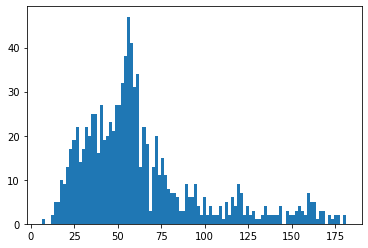

In [61]:
plt.hist(train_df[train_df["City"] == "Adapazarı"]["pm25_mid"], bins = 100)